In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
np.random.seed(88)
os.system('rm *.pdf *.eps *.png');

#### Problem definition

In [2]:
mu1 = [0,1]
mu2 = [1,0]
rho = -0.75
var = 0.02
fac = 0.5
cov1 = [[var,var*rho],[var*rho,var]]
cov2 = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]

In [3]:
def poststat(X,logalp):
    alp = np.exp(logalp)
    A = np.diag(alp)
    Pmat1 = la.inv(la.inv(cov1) + A)
    Pmat2 = la.inv(la.inv(cov2) + A)
    m1 = np.matmul(Pmat1,np.matmul(la.inv(cov1),mu1))
    m2 = np.matmul(Pmat2,np.matmul(la.inv(cov2),mu2))
    Bmat1 = la.inv(A) + cov1
    Bmat2 = la.inv(A) + cov2
    evid1 = st.multivariate_normal.pdf(mu1,[0,0],Bmat1) 
    evid2 = st.multivariate_normal.pdf(mu2,[0,0],Bmat2)
    evid = evid1+evid2
    w1 = evid1/evid
    w2 = evid2/evid
    postpdf = w1*st.multivariate_normal.pdf(X,m1,Pmat1) + w2*st.multivariate_normal.pdf(X,m2,Pmat2)
    priorpdf = st.multivariate_normal.pdf(X,[0,0],la.inv(A))
    likfun = st.multivariate_normal.pdf(X,mu1,cov1)+ st.multivariate_normal.pdf(X,mu2,cov2)
    v1 = [0.5*(1/alp[0] - Pmat1[0,0] + m1[0]**2),0.5*(1/alp[1] - Pmat1[1,1] + m1[1]**2)]
    v2 = [0.5*(1/alp[0] - Pmat2[0,0] + m2[0]**2),0.5*(1/alp[1] - Pmat2[1,1] + m2[1]**2)]
    jvec = [alp[0]*(w1*v1[0]+w2*v2[0]),alp[1]*(w1*v1[1]+w2*v2[1])]
    Hmat=np.zeros((2,2))
    Hmat[0,0] = alp[0]*alp[0]*(w1*(v1[0]*v1[0] + 0.5*Pmat1[0,0]**2) + w2*(v2[0]*v2[0] + 0.5*Pmat2[0,0]**2) - jvec[0]*jvec[0])
    Hmat[1,1] = alp[1]*alp[1]*(w1*(v1[1]*v1[1] + 0.5*Pmat1[1,1]**2) + w2*(v2[1]*v2[1] + 0.5*Pmat2[1,1]**2) - jvec[1]*jvec[1])
    Hmat[0,1] = alp[0]*alp[1]*(w1*(v1[0]*v1[1] + 0.5*Pmat1[0,1]**2) + w2*(v2[0]*v2[1] + 0.5*Pmat2[0,1]**2) - jvec[0]*jvec[1])
    Hmat[1,0] = Hmat[0,1]
    return likfun, priorpdf, postpdf, evid, jvec, Hmat

#### Plotting

In [4]:
mpl.rcParams.update({'font.size':12})
Ngrd  = 100
likfun   = np.zeros((Ngrd,Ngrd))
postdist = np.zeros((Ngrd,Ngrd))
priordist = np.zeros((Ngrd,Ngrd))
likfunc = np.zeros((Ngrd,Ngrd))
forEvid = np.zeros((Ngrd,Ngrd))
pltAlpha =[0,0]
X1bnd = [-2,2]
X2bnd = [-2,2]
X1g = np.linspace(X1bnd[0],X1bnd[1],Ngrd)
X2g = np.linspace(X2bnd[0],X2bnd[1],Ngrd)
X1grd,X2grd = np.meshgrid(X1g,X2g)
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        Xcur = [X1grd[i,j],X2grd[i,j]]
        likfunc[i,j],priordist[i,j],postdist[i,j],evd,Jevd,Hevd = poststat(Xcur,pltAlpha)
        forEvid[i,j] =  likfunc[i,j]*priordist[i,j]
evidraw = np.sum(forEvid)*(X1g[1]-X1g[0])*(X2g[1]-X2g[0])
print(evd,evidraw)

0.19162310236142593 0.19162310236142305


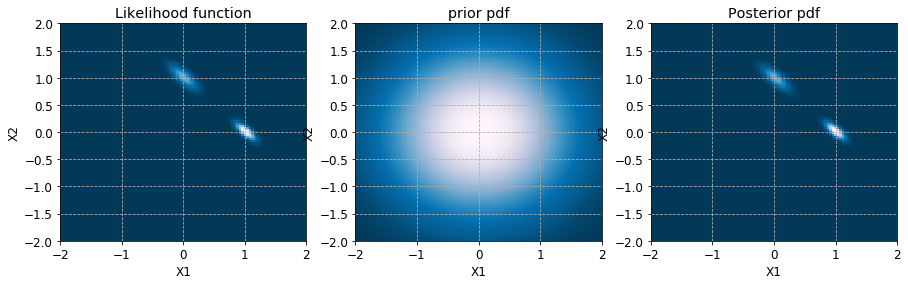

In [5]:
fig=plt.figure(1,figsize=(15,4))
plt.subplot(1, 3, 1)
plt.pcolor(X1grd,X2grd,likfunc,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Likelihood function')

plt.subplot(1, 3, 2)
plt.pcolor(X1grd,X2grd,priordist,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('prior pdf')

plt.subplot(1, 3, 3)
plt.pcolor(X1grd,X2grd,postdist,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Posterior pdf')
plt.savefig('evid2d_1.eps',bbox_inches='tight')

In [25]:
mpl.rcParams.update({'font.size':12})
Ngrd  = 100
evidplot   = np.zeros((Ngrd,Ngrd))
alp1bnd = [-10,10]
alp2bnd = [-10,10]
alp1g = np.linspace(alp1bnd[0],alp1bnd[1],Ngrd)
alp2g = np.linspace(alp2bnd[0],alp2bnd[1],Ngrd)
alp1grd,alp2grd = np.meshgrid(alp1g,alp2g)
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        alpCur = [alp1grd[i,j],alp2grd[i,j]]
        #lk,prt,pst,evidplot[i,j],Jevd,Hevd = poststat(Xcur,alpCur)
        lk,prt,pst,dd,jj,Hevd = poststat(Xcur,alpCur)
        evidplot[i,j] = jj[1]

0.7461343877554613 0.5903295347732771
[0.9901283745787517, 0.20261710471676134] [0.12808399496454684, 0.9828871002215179]


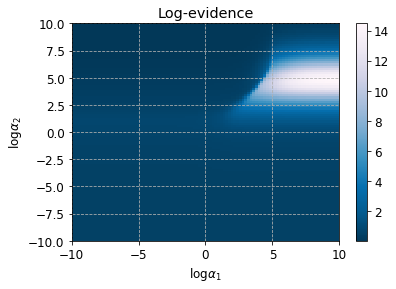

In [32]:
fig=plt.figure(2)
#plt.pcolor(alp1grd,alp2grd,np.log(evidplot),cmap='PuBu_r',vmin=-1.5)
plt.pcolor(alp1grd,alp2grd,evidplot,cmap='PuBu_r')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Log-evidence')
plt.savefig('evid2d_2.eps',bbox_inches='tight')
lk,prt,pst,ev1,Jev1,Hev1 = poststat(Xcur,[0,5])
lk,prt,pst,ev2,Jev2,Hev2 = poststat(Xcur,[5,0])
print(ev1,ev2)
print(Jev1,Jev2)